# Exploratory Data Analysis for predicting farm (Income) receipts using expenses
This notebook performs EDA on USDA data for aggrigated farm receipts and expense drivers, and fits a simple linear regression model.

In [9]:
# Install dependencies (run if needed)
# %pip install pandas numpy matplotlib seaborn scikit-learn openpyxl

In [10]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# helper functions to parse data sheets (specifically the united states sheet)
def _is_year(v):
    if isinstance(v, (int, float)) and not pd.isna(v):
        return 1900 <= int(v) <= 2100
    if isinstance(v, str):
        return bool(re.match(r"\d{4}", v))
    return False

def _find_year_row(df):
    for r in range(min(15, df.shape[0])):
        if sum(_is_year(x) for x in df.iloc[r, 1:15]) >= 3:
            return r
    raise ValueError("Year header row not found")

def _parse_years(row):
    yrs = []
    for v in row:
        if _is_year(v):
            yrs.append(int(re.match(r"(\d{4})", str(v)).group(1)) if isinstance(v, str) else int(v))
    return yrs

def parse_bea_sheet(df):
    yr_idx = _find_year_row(df)
    years = _parse_years(df.iloc[yr_idx, 1:].values)
    cols = [j for j in range(1, df.shape[1]) if _is_year(df.iloc[yr_idx, j])]
    start = yr_idx + 2
    data = {}
    for i in range(start, df.shape[0]):
        cat = df.iloc[i, 0]
        if isinstance(cat, str) and cat.strip() and not cat.lower().startswith('footnote'):
            vals = []
            for j in cols[:len(years)]:
                v = df.iloc[i, j]
                if isinstance(v, (int, float)):
                    vals.append(float(v))
                elif isinstance(v, str):
                    s = v.replace(',', '').replace('$','').replace(' ','').strip()
                    try:
                        vals.append(float(s))
                    except:
                        vals.append(np.nan)
                else:
                    vals.append(np.nan)
            if not all(pd.isna(vals)):
                data[cat.strip().lower()] = vals
    return pd.DataFrame(data, index=years)

# load data
income_statementPath = 'IncomeDataLarge_raw.xlsx'
exp_path = 'PE_State_US_raw.xlsx'
inc_df = parse_bea_sheet(pd.read_excel(income_statementPath, sheet_name='United States', header=None)).sort_index()
exp_df = parse_bea_sheet(pd.read_excel(exp_path, sheet_name='United States', header=None)).sort_index()

# Combine dataset
expense_cols = [c for c in ['seed','fertilizer, lime, and soil conditioner','fuel and oils',
                            'electricity','hired labor','pesticide',
                            'machine hire and custom work','marketing, storage, and transportation',
                            'nonreal estate interest'] if c in exp_df.columns]
data = pd.concat([inc_df['all commodity receipts'], exp_df[expense_cols]], axis=1).dropna()
data

,all commodity receipts,seed,"fertilizer, lime, and soil conditioner",fuel and oils,electricity,hired labor,pesticide,machine hire and custom work,"marketing, storage, and transportation",nonreal estate interest
1959,33647298.0,491253.0,1331923.0,1446926.0,161666.0,2300063.0,286400.0,583517.0,645094.0,649595.0
1960,34012148.0,519584.0,1343877.0,1483761.0,176746.0,2442917.0,289600.0,644961.0,678098.0,718834.0
1961,35163481.0,544566.0,1436930.0,1508324.0,200012.0,2531853.0,330200.0,612649.0,735226.0,740523.0
1962,36468521.0,565436.0,1544066.0,1511941.0,215384.0,2620759.0,368100.0,621502.0,761059.0,808974.0
1963,37477136.0,618785.0,1712126.0,1534560.0,228361.0,2709665.0,378900.0,660774.0,757017.0,904576.0
...,...,...,...,...,...,...,...,...,...,...
2021,442416992.0,22315477.0,29543871.0,13926644.0,6383375.0,30001176.0,17818244.0,4864037.0,10476671.0,6269609.0
2022,542610690.0,25024419.0,36634310.0,18485372.0,6412774.0,35156295.0,21417212.0,5382525.0,11185230.0,7980779.0
2023,516945817.0,27326665.0,35833560.0,17605979.0,7072529.0,41201837.0,21617373.0,6317601.0,12658945.0,10459553.0
2024,516802531.0,26608549.0,32883795.0,15484821.0,7484196.0,43937712.0,19296316.0,6159893.0,13485065.0,11023327.0


## Summary Statistics

In [11]:
data.describe()

,all commodity receipts,seed,"fertilizer, lime, and soil conditioner",fuel and oils,electricity,hired labor,pesticide,machine hire and custom work,"marketing, storage, and transportation",nonreal estate interest
count,6.700000e+01,6.700000e+01,6.700000e+01,6.700000e+01,6.700000e+01,6.700000e+01,6.700000e+01,6.700000e+01,6.700000e+01,6.700000e+01
mean,2.039819e+08,8.757372e+06,1.224640e+07,7.609854e+06,2.872320e+06,1.493284e+07,7.376850e+06,3.006945e+06,5.598299e+06,5.625027e+06
std,1.409282e+08,8.572082e+06,9.692859e+06,5.212803e+06,2.174880e+06,1.115815e+07,5.985651e+06,1.661706e+06,3.922389e+06,2.932784e+06
min,3.364730e+07,4.912530e+05,1.331923e+06,1.446926e+06,1.616660e+05,2.300063e+06,2.864000e+05,5.835170e+05,6.450940e+05,6.495950e+05
25%,9.387293e+07,2.252000e+06,6.460304e+06,3.642265e+06,7.257030e+05,5.834832e+06,1.860242e+06,1.543505e+06,1.184688e+06,3.321396e+06
50%,1.714702e+08,5.113063e+06,9.177134e+06,5.979082e+06,2.647637e+06,1.190984e+07,6.470512e+06,3.097989e+06,4.718612e+06,6.410037e+06
75%,3.029713e+08,1.532626e+07,2.058654e+07,1.245813e+07,4.578278e+06,2.359877e+07,1.111934e+07,4.204198e+06,8.952536e+06,6.939221e+06
max,5.426107e+08,2.771750e+07,3.663431e+07,1.848537e+07,7.601770e+06,4.536896e+07,2.161737e+07,6.407676e+06,1.399478e+07,1.134913e+07


## Time Series Plot of Receipts and Expenses

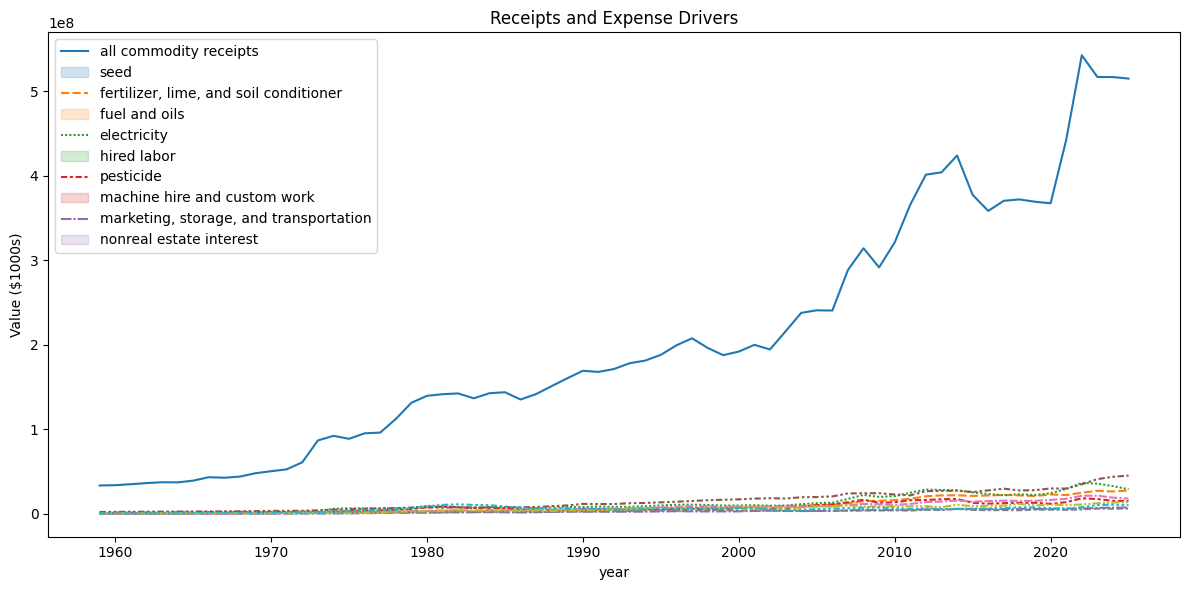

In [12]:
plt.figure(figsize=(12,6))
sns.lineplot(data=data)
plt.title('Receipts and Expense Drivers')
plt.xlabel('year')
plt.ylabel('Value ($1000s)')
plt.legend(data.columns, loc='upper left')
plt.tight_layout()
plt.show()

## Correlation heatmap (matrix)

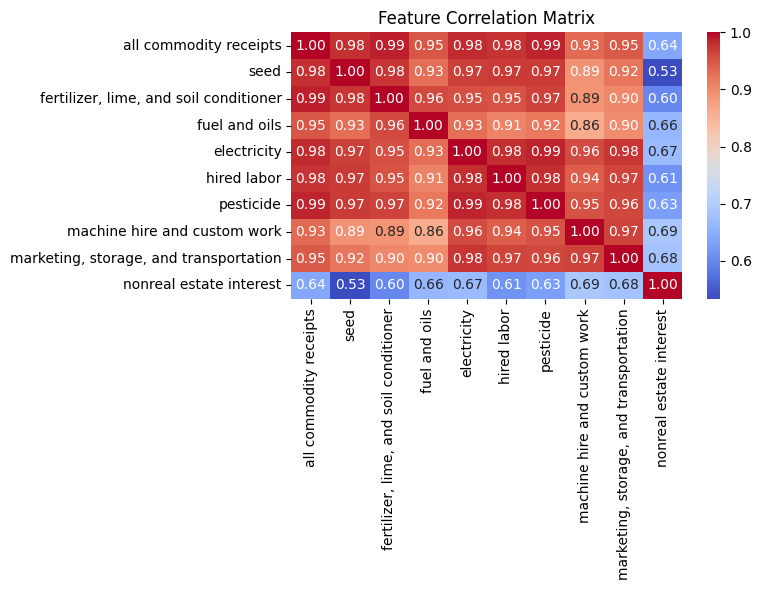

In [13]:
plt.figure(figsize=(8,6))
corr = data.corr()
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

## Pairplot of the features

c:\Users\Risha\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


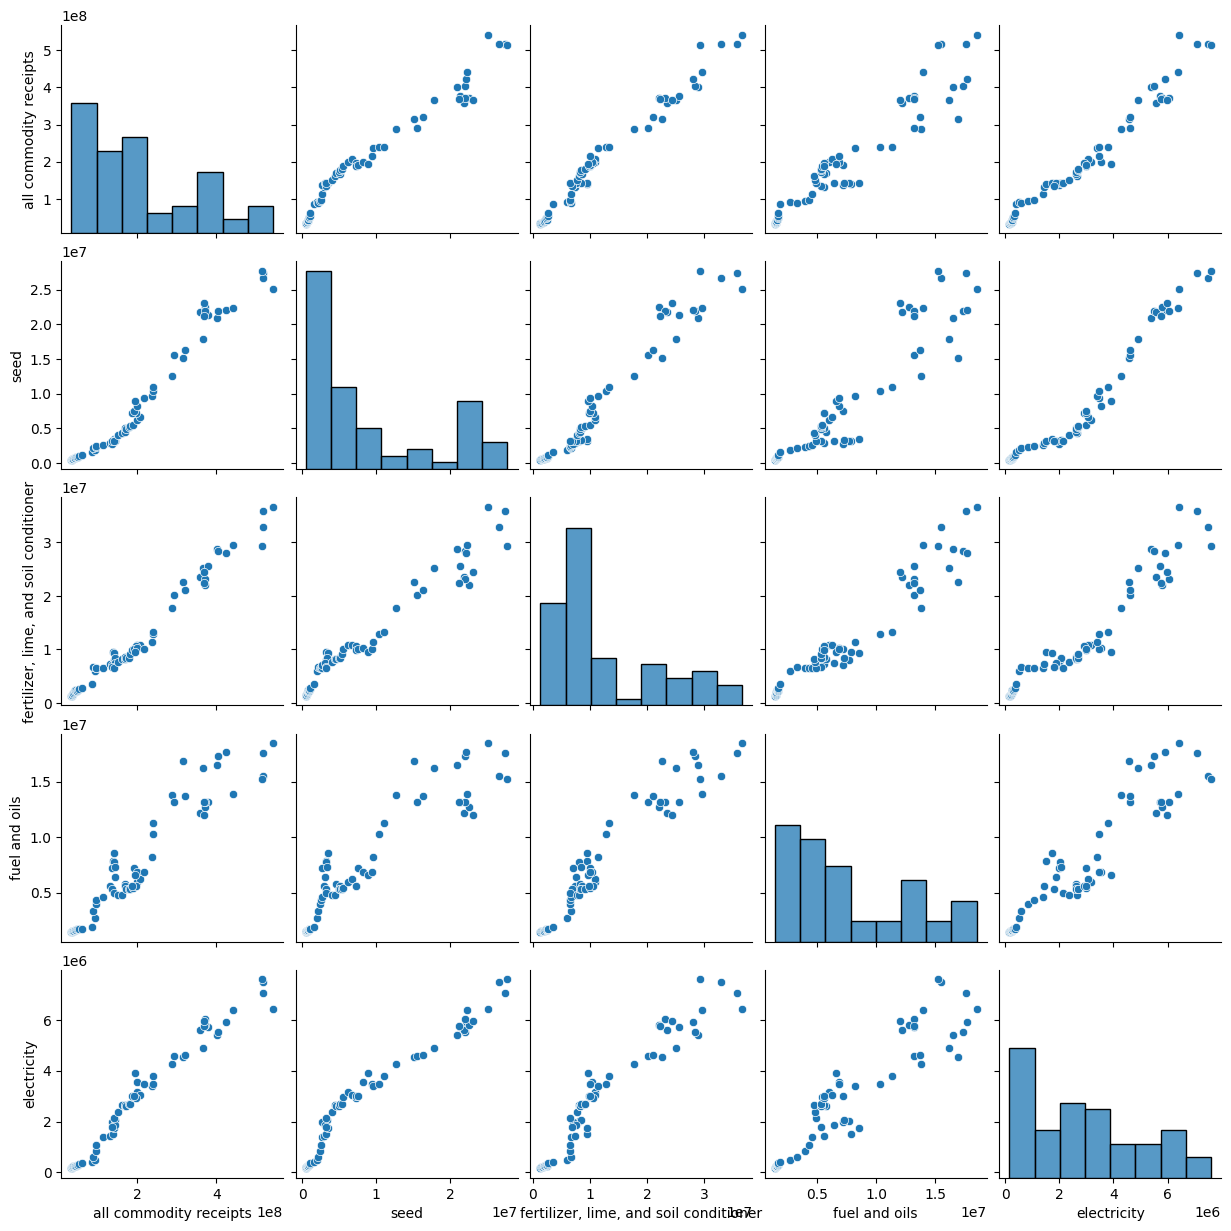

In [14]:
sns.pairplot(data.iloc[:, :5])  # only the first 5 columns for readability
plt.show()

## Simple linear regression of electricity and all commodity receipts

coefficient: 63.6954, intercept: 21028320.0693, R^2: 0.9663


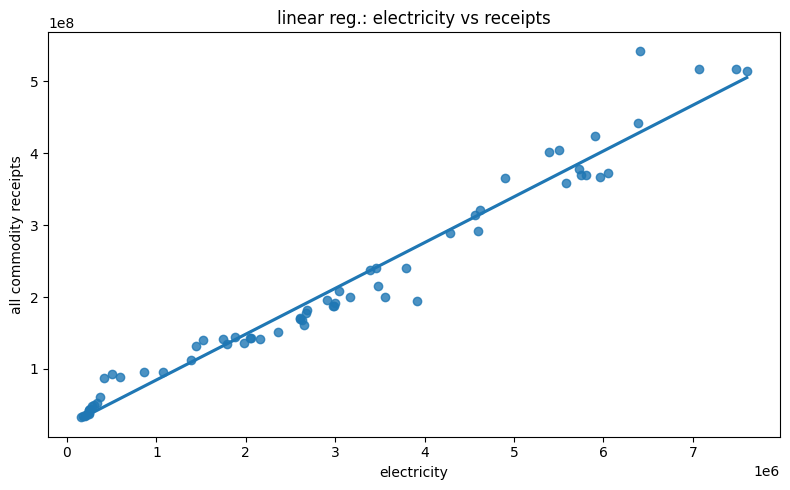

In [15]:
# prepare variables
X_electricity = data[['electricity']].values
y_all_commodity_reciepts = data['all commodity receipts'].values

# fit the simple linear regression model
simple_linear_reg = LinearRegression()
simple_linear_reg.fit(X_electricity, y_all_commodity_reciepts)
y_pred = simple_linear_reg.predict(X_electricity)
print(f'coefficient: {simple_linear_reg.coef_[0]:.4f}, intercept: {simple_linear_reg.intercept_:.4f}, R^2: {r2_score(y_all_commodity_reciepts, y_pred):.4f}')

# plot the regression of electricity vs reciepts
plt.figure(figsize=(8,5))
sns.regplot(x='electricity', y='all commodity receipts', data=data, ci=None)
plt.title('linear reg.: electricity vs receipts')
plt.tight_layout()
plt.show()

## multivariable linear regression

intercept: 15871163.9664
seed: -2.5171
fertilizer, lime, and soil conditioner: 8.1580
fuel and oils: -0.0474
electricity: 20.5525
hired labor: 2.7217
pesticide: 2.7766
machine hire and custom work: -0.1832
marketing, storage, and transportation: -1.7647
nonreal estate interest: 0.1564
R^2: 0.9950


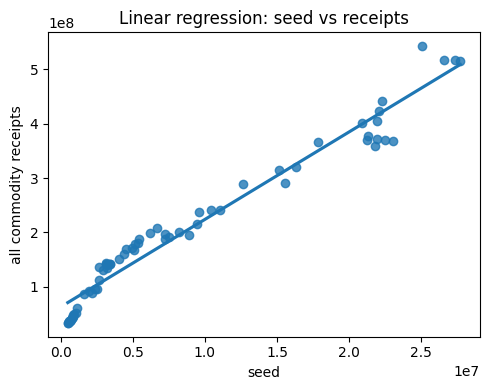

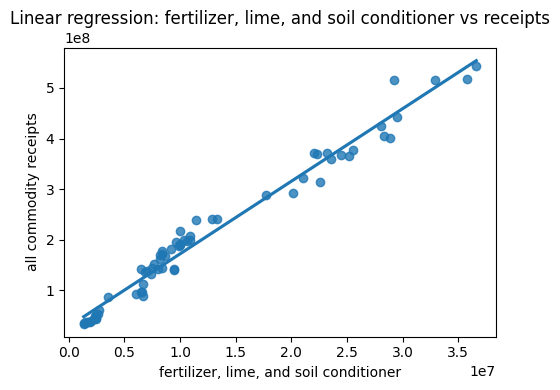

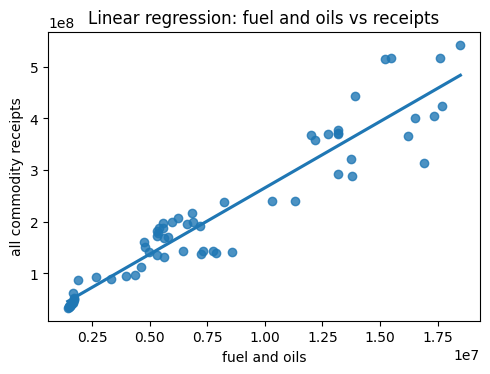

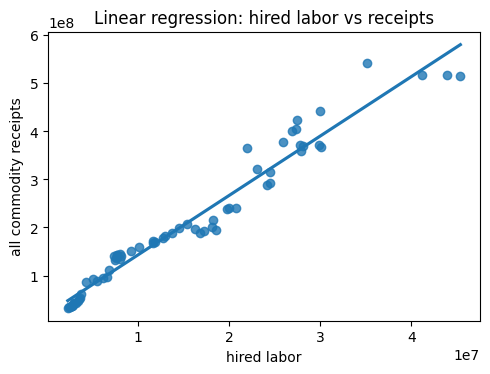

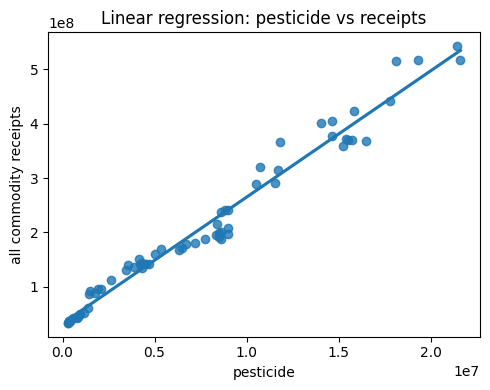

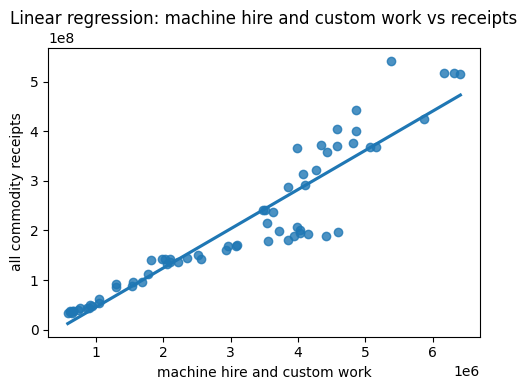

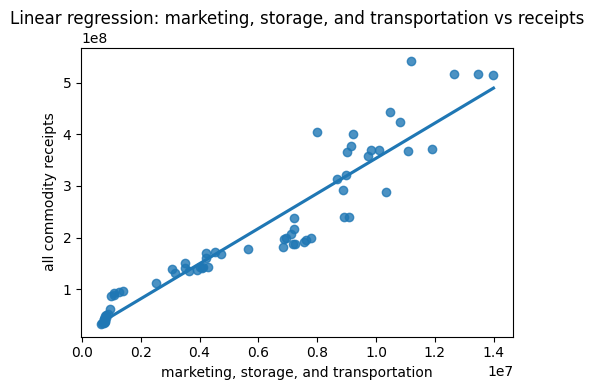

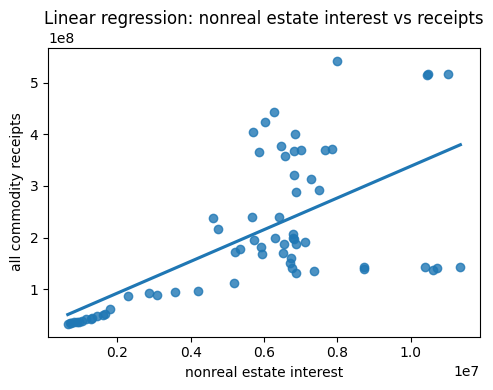

In [16]:
# multi variable linear regression on all expense features
X_all = data[expense_cols].values
multivar_linear_reg_all = LinearRegression()
multivar_linear_reg_all.fit(X_all, y_all_commodity_reciepts)
y_all_pred = multivar_linear_reg_all.predict(X_all)
print(f'intercept: {multivar_linear_reg_all.intercept_:.4f}')
for feat, coef in zip(expense_cols, multivar_linear_reg_all.coef_):
    print(f'{feat}: {coef:.4f}')
print(f'R^2: {r2_score(y_all_commodity_reciepts, y_all_pred):.4f}')

# graph each of 
for exp in expense_cols:
    if exp == "electricity":
        continue
    plt.figure(figsize=(5, 4))
    sns.regplot(x=exp, y='all commodity receipts', data=data, ci=None)
    plt.title(f'Linear regression: {exp} vs receipts')
    plt.tight_layout()
    plt.show()
